# Machine Learning Fundamentals - Lecture 04

This is the Jupyter notebook for Lecture 04 of the Machine Learning Fundamentals
course.

In [13]:
# Import the required libraries using the commonly use short names (pd, sns, ...)
import numpy as np
import pandas as pd
import seaborn as sns
import cycler

# The Path object from pathlib allows us to easily build paths in an
# OS-independent fashion
from pathlib import Path

# Import the cycle function from itertools to help with cycling through colors
from itertools import cycle

# Load the required scikit-learn classes and functions
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats

# Get the colors array from the current matplotlib colormap
# We'll cycle through these predefined colors in each plot to keep consistency
# and so that our plots don't look horrible with colors chosen by us
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Part 1: load and clean the Pokémon dataset

Here we just repeat the steps already done in the previous lectures, but in a
more succint way.

In [14]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("Pokemon.csv"))

# it's not good practice to have column names with spaces and other non-standard
# characters, so Let's fix this by renaming the columns to standard names
df.rename(columns={
    "Type 1" : "Type1",
    "Type 2" : "Type2",
    "Sp. Atk" : "SpAtk",
    "Sp. Def" : "SpDef",
}, inplace=True)

# Replace missing values in the "Type2" column with the string "None"
df["Type2"] = df["Type2"].fillna("None")

# Since primary and secondary types are essentially categories (and not just
# strings / objects), we can convert these columns to the category type
df["Type1"] = df["Type1"].astype("category")
df["Type2"] = df["Type2"].astype("category")

## Part 2: Visualize the 1D regression function for predicting Total from Attack

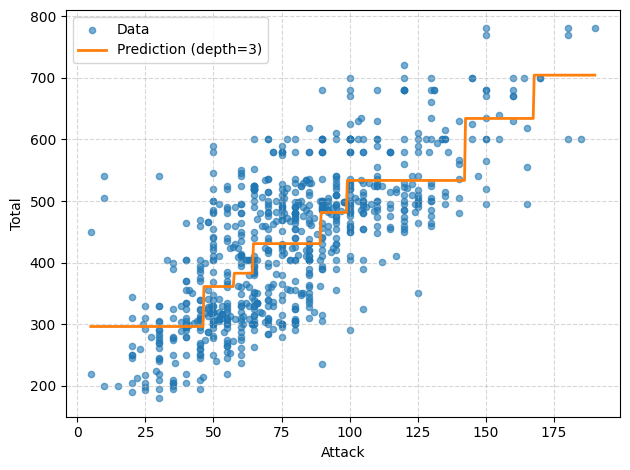

In [15]:
# 1D regression: predict Total from Attack
X = df[["Attack"]].to_numpy()
y = df["Total"].to_numpy()

# Max depth: change this to see how the regression line changes
max_depth = 3

# Fit regression tree
# - Note we're using the whole training data! Our goal here is only to plot a
# (mostly) continuous regression line so we get an intuition of how the
# decision tree regressor works
# - See part 4 below to see an actual prediction being made
tree_1d = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_1d.fit(X, y)

# Create test data for plotting: we basically create a lot of points so we can
# draw a continuous line connecting them
# The reshape(-1, 1) at the end converts the vector returned by linspace into
# a [500, 1] matrix (the -1 means use the complete length of values)
X_test = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred = tree_1d.predict(X_test)

# Let's create the plot
cycler = cycle(colors) # Color cycler
fig1, ax1 = plt.subplots()
ax1.scatter(X, y, s=20, alpha=0.6, color=next(cycler), label="Data")
ax1.plot(X_test, y_pred, color=next(cycler), linewidth=2, label=f"Prediction (depth={max_depth})")
ax1.set_xlabel("Attack")
ax1.set_ylabel("Total")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)
fig1.tight_layout()

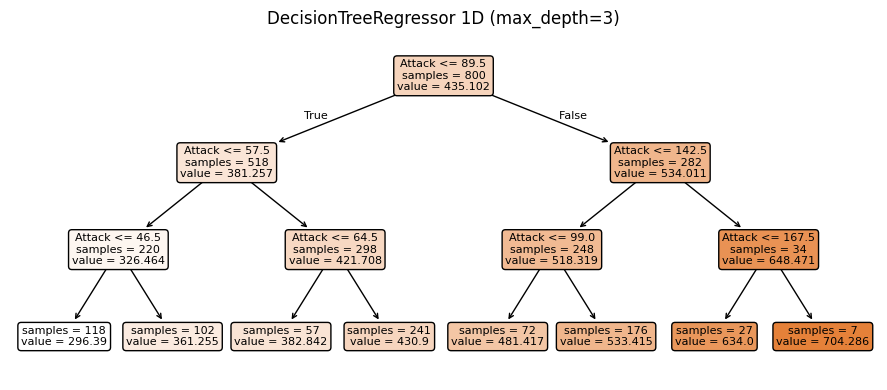

In [16]:
# Let's check out the actual regression tree created by the regressor above
fig1t, ax1t = plt.subplots(figsize=(9, 4))
plot_tree(
    tree_1d,
    feature_names=["Attack"],
    filled=True,
    rounded=True,
    impurity=False,
    proportion=False,
    fontsize=8,
    ax=ax1t
)

ax1t.set_title(f"DecisionTreeRegressor 1D (max_depth={max_depth})")
fig1t.tight_layout()

Note that the CART algorithm (employed in scikit-learn) reuses features at each
tree level, contrary to what is done by ID3.

## Part 3: Visualize the 2D regression function for predicting Total from Attack and Defense

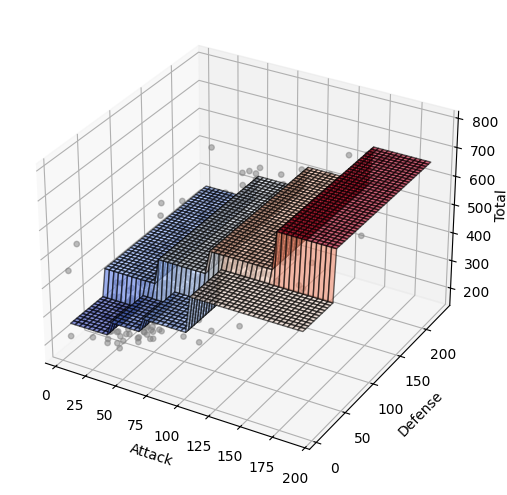

In [17]:
# 2D regression: predict Total from Attack and Defense ---
X2 = df[["Attack", "Defense"]].values
y2 = df["Total"].values

# Max depth: change this to see how the regression line changes
max_depth = 3

# Fit regression tree
# - Note we're using the whole training data! Our goal here is only to plot a
# (mostly) continuous regression planes so we get an intuition of how the
# decision tree regressor works in 2D regression
# - See part 4 below to see an actual prediction being made
tree_2d = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_2d.fit(X2, y2)

# Create test data for plotting: we basically create a lot of points so we can
# draw a continuous line connecting them. Let's go step by step, as this is
# somewhat more convoluted than in the 1D case:

# Create equally spaced points for each of the 2 dimensions
# We're basing ourselves in the actual dimension of the train data (attack and defense)
x1 = np.linspace(X2[:, 0].min(), X2[:, 0].max(), 50)
x2 = np.linspace(X2[:, 1].min(), X2[:, 1].max(), 50)

# Get a tuple of coordinate matrices from coordinate vectors (basically create a
# grid of all combinations of x1 and x2 values)
xx1, xx2 = np.meshgrid(x1, x2)

# Combine xx1 and xx2: now we get a proper "X" matrix, with rows being
# observations and columns the features (50x50=2500 observations, 2 features)
X_grid = np.column_stack((xx1.ravel(), xx2.ravel()))

# Perform the prediction over all of these "training" points to get the
# regression planes
y_pred2 = tree_2d.predict(X_grid).reshape(xx1.shape)

# Let's create the plot
fig2 = plt.figure(figsize=(5, 5))
ax2 = fig2.add_subplot(111, projection="3d")

# Plot the actual data points, so we can have some insight on how the regression
# planes are predicted
ax2.scatter(X2[:, 0], X2[:, 1], y2, color="gray", s=15, alpha=0.5, label="Data")

# Plot regression "surface" (piecewise-constant planes)
ax2.plot_surface(xx1, xx2, y_pred2, cmap="coolwarm", alpha=0.6, edgecolor="k")

ax2.set_xlabel("Attack")
ax2.set_ylabel("Defense")
ax2.set_zlabel("Total", labelpad=0)

fig2.tight_layout()

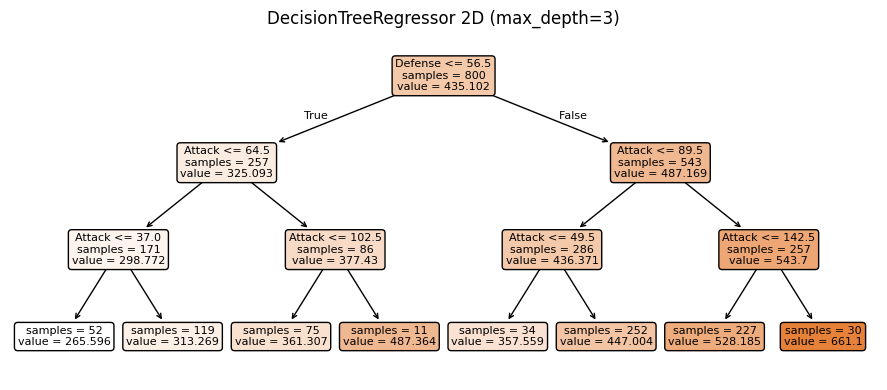

In [18]:
# Let's check out the actual regression tree created by the 2D regressor above
fig2t, ax2t = plt.subplots(figsize=(9, 4))

plot_tree(
    tree_2d,
    feature_names=["Attack", "Defense"],
    filled=True,
    rounded=True,
    impurity=False,
    proportion=False,
    fontsize=8,
    ax=ax2t
)

ax2t.set_title(f"DecisionTreeRegressor 2D (max_depth={max_depth})")
fig2t.tight_layout()

## Part 4: Compare $R^2$ for different tree depths

$R^2$, also called the _coefficient of determination_, measures how well a
regression model's predictions match the actual data. It represents the
proportion of variance in the target variable that's explained by the model.

An $R^2$ of 1 means perfect predictions, 0 means the model is no better than
predicting the mean, and negative values mean it's worse than that.

In this part we'll take a look at how $R^2$ changes for different values of
`max_depth` for the 1D regression tree case. For this purpose, we'll train two
tree models with different depths using only the training data. The test data
will be used to assess how well each tree generalizes beyond the training data.

We'll plot the regression lines anyway, which gives us an idea of how far the
test data is from those lines. The farthest the test data is from those lines,
the lowest $R^2$ will be (which means a worse prediction).

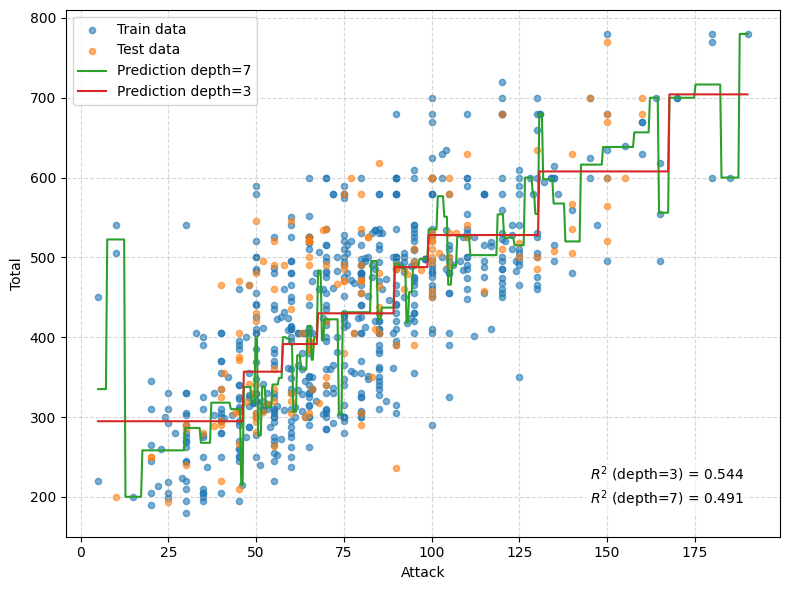

In [19]:

# 1D regression: predict Total from Attack
X = df[["Attack"]].to_numpy()
y = df["Total"].to_numpy()

# Split into training and test sets, no need for scaling in Decision Trees
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit regression tree for different max_depths
tree_1d_depth3 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_1d_depth3.fit(X_train, y_train)

tree_1d_depth7 = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_1d_depth7.fit(X_train, y_train)

# Create test grid for plotting the regression lines
X_pred_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred_plot_depth3 = tree_1d_depth3.predict(X_pred_plot)
y_pred_plot_depth7 = tree_1d_depth7.predict(X_pred_plot)

# Make the actual predictions with test data for which we have the true labels
y_pred_test_depth3 = tree_1d_depth3.predict(X_test)
y_pred_test_depth7 = tree_1d_depth7.predict(X_test)

# Get the R^2 scores for each three
r2_d3 = r2_score(y_test, y_pred_test_depth3)
r2_d7 = r2_score(y_test, y_pred_test_depth7)

# Create a new color cycler
cycler = cycle(colors)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# First, plot the training data
ax.scatter(X_train, y_train, s=20, color=next(cycler), alpha=0.6, label="Train data")

# Then the test data
ax.scatter(X_test.ravel(), y_test, s=20, color=next(cycler), alpha=0.6, label="Test data")

# Now let's plot the regression lines for each tree
ax.plot(X_pred_plot, y_pred_plot_depth7, color=next(cycler), linewidth=1.5, label="Prediction depth=7")
ax.plot(X_pred_plot, y_pred_plot_depth3, color=next(cycler), linewidth=1.5, label="Prediction depth=3")

# Labels, legend, and background grid
ax.set_xlabel("Attack")
ax.set_ylabel("Total")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# Present the R^2's directly in the figure
ax.text(
    0.95, 0.05, # (x, y) in axes fraction coordinates
    f"$R^2$ (depth=3) = {r2_d3:.3f}\n$R^2$ (depth=7) = {r2_d7:.3f}",
    transform=ax.transAxes, # interpret (x, y) as fraction of Axes
    ha="right", va="bottom", # align text to right bottom corner
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
)

fig.tight_layout()

The regression line for depth=7, in green, shows that the tree overfits the
train data, while for depth=3, the regression line just follows the general
trend, without "becoming addicted" to specific training data details.

We confirm that the tree with depth=3 generalizes better to the test data, since
it has a higher $R^2$ than the tree with depth=7.

# Mini Project 4: Implement Linear Regression

In [20]:
# -------------------------------------------
# 1D Linear Regression (SLR) Implementation
# -------------------------------------------

def linearRegressionSLR(X, y):
    """
    Perform simple linear regression on 1D data. Using Ordinary Least Squares (OLS). 
    The linear model is y = a*x + b, where a is the slope and b is the intercept.
    """
    # Convert to numpy arrays and flatten to 1D arrays
    x = np.asarray(X).ravel()
    y = np.asarray(y).ravel()
    
    # Compute means of x and y
    mx = x.mean()
    my = y.mean()
    
    # Compute slope (a) and intercept (b) of the regression line
    a = np.sum((x - mx)*(y - my)) / np.sum((x - mx)**2)
    b = my - a*mx
    
    # Return the parameters
    return a, b

def predictSLR(X, a, b):
    """
    Predict using the linear regression parameters.
    """
    # Predict y values using the linear model y = a*x + b
    y_pred = a * X + b
    
    return y_pred

### Testing 1D Linear Regression sklearn vs Manual Implementation 1D Linear Regression

Mean Absolute Error: 61.7980
Mean Absolute Percentage Error: 0.1477

Mean Absolute Error (manual): 61.7980
Mean Absolute Percentage Error (manual): 0.1477


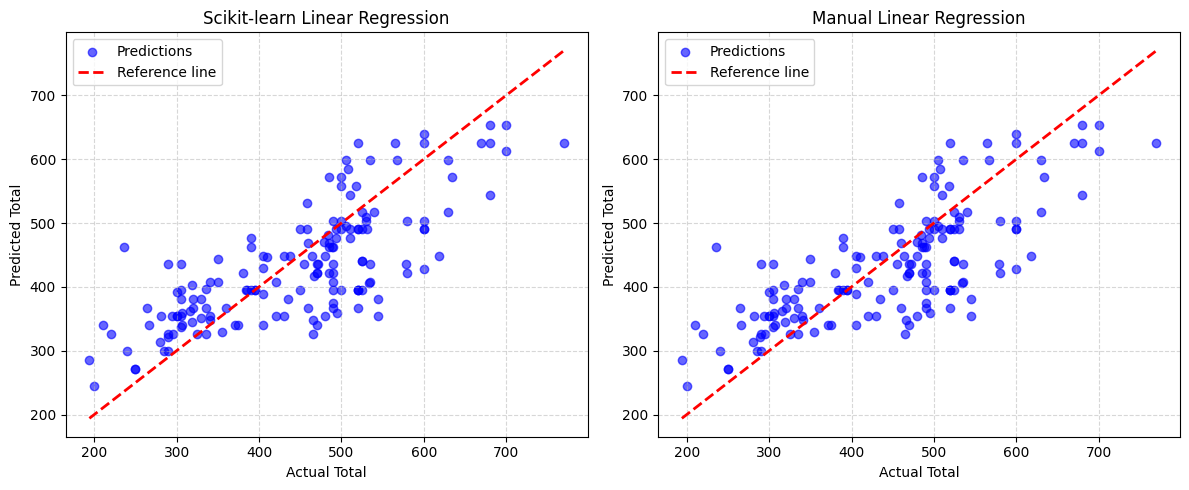

In [21]:
X = df[["Attack"]].to_numpy()
y = df["Total"].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# -------------------------------------------
# Sklearn implementation
# -------------------------------------------

# Train linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Metrics mean absolute error and mean absolute percentage error
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}\n")


# -------------------------------------------
# Manual implementation
# -------------------------------------------

# Train linear regression
a, b = linearRegressionSLR(X_train, y_train)

# Predict
y_pred_manual = predictSLR(X_test, a, b)

# Metrics mean absolute error and mean absolute percentage error
mae_manual = mean_absolute_error(y_test, y_pred_manual)
mape_manual = mean_absolute_percentage_error(y_test, y_pred_manual)

print(f"Mean Absolute Error (manual): {mae_manual:.4f}")
print(f"Mean Absolute Percentage Error (manual): {mape_manual:.4f}")


# --------------------------------------------
# Plot results
# --------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

# Scikit-learn Linear Regression
axes[0].scatter(y_test, y_pred, alpha=0.6, color='blue', label="Predictions")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', linewidth=2, label="Reference line")
axes[0].set_title("Scikit-learn Linear Regression")
axes[0].set_xlabel("Actual Total")
axes[0].set_ylabel("Predicted Total")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# Manual Linear Regression
axes[1].scatter(y_test, y_pred_manual, alpha=0.6, color='blue', label="Predictions")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', linewidth=2, label="Reference line")
axes[1].set_title("Manual Linear Regression")
axes[1].set_xlabel("Actual Total")
axes[1].set_ylabel("Predicted Total")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### R² comparison between decision tree vs linear regression vs manual implementation

R² (Decision Tree, depth=3): 0.5445
R² (Sklearn Linear Regression): 0.5680
R² (Manual Linear Regression): 0.5680


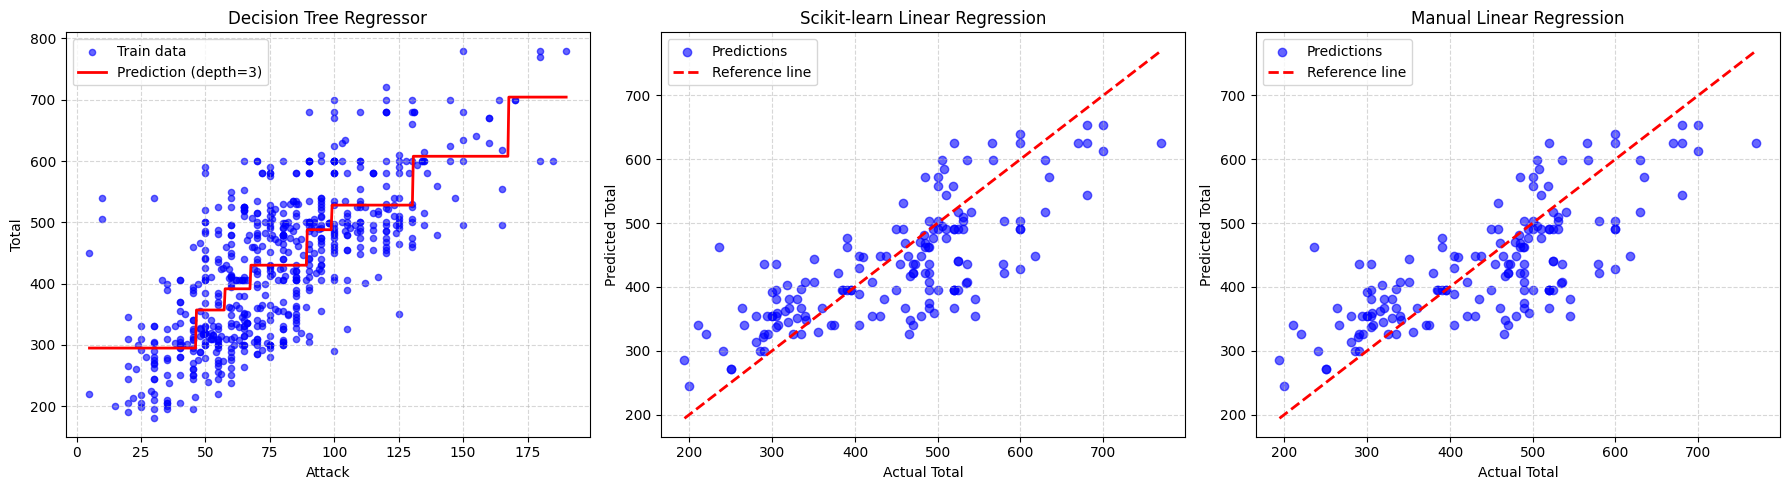

In [22]:
X = df[["Attack"]].to_numpy()
y = df["Total"].to_numpy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the figure and axes (3 panels)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)


# --------------------------------------------
# Decision Tree Regressor
# --------------------------------------------

max_depth = 3
tree_1d = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_1d.fit(X_train, y_train)

# Predictions for plot
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred_tree_plot = tree_1d.predict(X_plot)

axes[0].scatter(X_train, y_train, s=20, alpha=0.6, color='blue', label="Train data")
axes[0].plot(X_plot, y_pred_tree_plot, color='red', linewidth=2, label=f"Prediction (depth={max_depth})")
axes[0].set_title("Decision Tree Regressor")
axes[0].set_xlabel("Attack")
axes[0].set_ylabel("Total")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

y_pred_tree = tree_1d.predict(X_test)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"R² (Decision Tree, depth={max_depth}): {r2_tree:.4f}")


# --------------------------------------------
# sklearn Linear Regression
# --------------------------------------------

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)

axes[1].scatter(y_test, y_pred_lr, alpha=0.6, color='blue', label="Predictions")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', linewidth=2, label="Reference line")
axes[1].set_title("Scikit-learn Linear Regression")
axes[1].set_xlabel("Actual Total")
axes[1].set_ylabel("Predicted Total")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

r2_sklearn = r2_score(y_test, y_pred_lr)
print(f"R² (Sklearn Linear Regression): {r2_sklearn:.4f}")


# --------------------------------------------
# Manual Linear Regression
# --------------------------------------------

a, b = linearRegressionSLR(X_train, y_train)
y_pred_manual = predictSLR(X_test, a, b)

axes[2].scatter(y_test, y_pred_manual, alpha=0.6, color='blue', label="Predictions")
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', linewidth=2, label="Reference line")
axes[2].set_title("Manual Linear Regression")
axes[2].set_xlabel("Actual Total")
axes[2].set_ylabel("Predicted Total")
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.5)

r2_manual = r2_score(y_test, y_pred_manual)
print(f"R² (Manual Linear Regression): {r2_manual:.4f}")

plt.tight_layout()
plt.show()

### Comparison and Interpretation

**R² results:**  
- Decision Tree (depth = 3): **0.5445**  
- Scikit-learn Linear Regression: **0.5680**  
- Manual Linear Regression: **0.5680**

**Interpretation of R²:**  
R² (coefficient of determination) measures how much of the variance in the target variable (`Total`) is explained by the model.  
- R² = 1 --> perfect fit  
- R² = 0 --> model explains nothing beyond the mean  
- R² < 0 --> model worse than simply predicting the mean  

Here, both linear regressions explain about **57 % of the variation** in `Total`, while the Decision Tree explains around **54 %**.  
Even after increasing `max_depth` from 1 to 3, the Decision Tree still performs slightly worse.  
This happens because the relationship between `Attack` and `Total` is fundamentally **linear**, and the Linear Regression is designed to capture such patterns optimally.

A Decision Tree, by contrast, divides the x-axis into discrete regions and predicts the **average** value in each region, producing a **step-like curve**.  
Even with more depth, it cannot form a continuous slope like the linear model.
Therefore, the Linear Regression consistently achieves a slightly higher R², and in purely linear 1D data, the tree can approach but **never outperform** it.

**Main differences between regressors:**  
The **Linear Regression** creates a single equation `y = a*x + b` that captures the overall linear trend between variables.  
The **Decision Tree Regressor** builds a series of conditional splits (`if Attack <= threshold`) and assigns constant predictions in each interval.  
This makes the tree better suited for **non-linear or threshold-based relationships**, while the linear model remains superior when the underlying pattern is linear.

In [23]:
# -------------------------------------------
# Multiple Linear Regression (MLR) Implementation
# -------------------------------------------

def linearRegressionMLR(X, y):
    """
    Perform multiple linear regression using Ordinary Least Squares (OLS).
    Formula: w = (Xᵀ * X)⁻¹ * Xᵀ * y
    where:
        X --> matrix of features
        y --> target vector
        w --> vector of coefficients (including intercept if desired)
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    
    # Compute coefficients using the normal equation
    XTX = np.dot(X.T, X) # Xᵀ * X
    XTy = np.dot(X.T, y) # Xᵀ * y
    w = np.dot(np.linalg.inv(XTX), XTy) # (Xᵀ * X)⁻¹ * Xᵀ * y
    
    return w


def predictMLR(X, w):
    """
    Predict y values using the learned coefficients.
    Formula: y_pred = X * w
    """
    X = np.asarray(X)
    return np.dot(X, w)

### Testing the Multidimensional Linear Regression sklearn vs Manual Implementation multidimensional Linear Regression

In [ ]:
# Select all numeric features
X = df[["HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed"]].values
y = df["Total"].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------
# sklearn multidimensional Linear Regression
# --------------------------------------------

# Train linear model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# R² score
r2 = r2_score(y_test, y_pred)
print(f"R² (Multiple Linear Regression): {r2:.4f}")


# --------------------------------------------
# Manual multidimensional Linear Regression
# --------------------------------------------

theta = linearRegressionMLR(X_train, y_train)
# Predict
y_pred_manual = predictMLR(X_test, theta)
# R² score
r2_manual = r2_score(y_test, y_pred_manual)
print(f"R² (Manual Multidimensional Linear Regression): {r2_manual:.4f}")

R² (Multiple Linear Regression): 1.0000
R² (Manual Multidimensional Linear Regression): 1.0000


# Linear Regression Implementation (Report)
## 1D Linear Regression (SLR)
Simple Linear Regression (SLR) is a statistical model used to find the best straight line that explains the relationship between two variables.  
The line has the form:

`y = a*x + b`

- `a` -> slope of the line (how much y changes for each unit of x)
- `b` -> intercept (the value of y when x = 0)

The goal is to find the values of `a` and `b` that minimize the total squared error between the predicted and actual values.

---

### Function: linearRegressionSLR(X, y)

Find the slope (`a`) and intercept (`b`) that best fit the data points (X, y).

#### Step by step

```python
x = np.asarray(X).ravel()
y = np.asarray(y).ravel()
```

- `np.asarray()` converts a list, pandas Series, or other data type into a NumPy array.  
  NumPy arrays are used because they allow efficient mathematical operations.

- `.ravel()` flattens the array into one single dimension.  
  For example:
  ```
  [[1], [2], [3]] -> [1, 2, 3]
  ```
  This ensures that even if the data was given as a column (2D), it becomes a 1D vector, which is required for the regression formulas.

---

```python
mx = x.mean()
my = y.mean()
```

- Calculates the mean (average) of x and y.
- These means are used to center the data around the average values before computing the slope.

---

```python
a = np.sum((x - mx)*(y - my)) / np.sum((x - mx)**2)
```

- `(x - mx)` and `(y - my)` subtract the mean from each element, giving how far each point is from the average.
- The numerator `np.sum((x - mx)*(y - my))` measures the covariance between x and y.
- The denominator `np.sum((x - mx)**2)` measures the variance of x.
- Dividing these two gives the slope `a`, representing how y changes when x increases.

---

```python
b = my - a*mx
```

- Once the slope is known, the intercept `b` is calculated using the average values of x and y.
- It represents where the line crosses the y-axis (the predicted y when x = 0).

---

```python
return a, b
```

- Returns both parameters of the model.

---

### Function: predictSLR(X, a, b)

Generate predictions using the learned model parameters.

```python
y_pred = a * X + b
```

- Applies the linear equation directly to all x values.
- If `X` is a NumPy array, this operation is vectorized — it computes all results at once, without loops.

```python
return y_pred
```

- Returns the array of predicted y values.

## Multiple Linear Regression (MLR)

Multiple Linear Regression (MLR) extends the same concept to **more than one input variable**.  
Instead of a line, the model fits a **plane** (in 2D) or a **hyperplane** (in higher dimensions) that best predicts the output.  
The general model is:

`y = w1*x1 + w2*x2 + ... + wn*xn + b`

- Each `wi` -> represents the contribution of feature `xi` to the target.  
- `b` -> intercept (the value of y when all features are zero).

The goal is the same: find the coefficients that minimize the sum of squared residuals between predicted and actual values.

---

### Function: linearRegressionMLR(X, y)

Compute all coefficients (`w`) for multiple features using the **Ordinary Least Squares (OLS)** method.

#### Step by step

```python
X = np.asarray(X)
y = np.asarray(y).ravel()
```

- Converts the features matrix `X` and target vector `y` into NumPy arrays.  
- Ensures that `y` is 1D, because NumPy operations expect `(n,)` shape, not `(n,1)`.

---

```python
XTX = np.dot(X.T, X)
```

- Calculates `Xᵀ * X`, the correlation between all pairs of features. 
- `np.dot()` performs matrix multiplication.
- The result is a square matrix `(n_features x n_features)` that represents how each variable relates to the others.

---

```python
XTy = np.dot(X.T, y)
```

- Computes `Xᵀ * y`, the correlation between each feature and the target variable.
- `np.dot()` again performs matrix multiplication.
- The result is a vector `(n_features,)` that shows how each feature relates to the target.

---

```python
w = np.dot(np.linalg.inv(XTX), XTy)
```

- Applies the **normal equation** to find the coefficients:  
  `(Xᵀ X)⁻¹ Xᵀ y`
- `np.linalg.inv(XTX)` computes the inverse of the matrix `Xᵀ X`.
- `np.dot(..., XTy)` multiplies the inverse with `Xᵀ y` to get the coefficients.
- This is the closed-form OLS solution that minimizes the total squared error.
- The result `w` is a vector of coefficients — one for each feature.

---

```python
return w
```

- Returns the array of learned weights.

---

### Function: predictMLR(X, w)

Predict the target values `y_pred` using the learned coefficients.

```python
y_pred = np.dot(X, w)
```

- Performs the matrix multiplication (`np.dot()`) between the features matrix `X` and the weights vector `w`.
- This computes the predicted values for all samples in one go.
  
```python
return y_pred
```

- Returns the vector of predictions.
